In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
import os
import joblib
import time
import psutil

# Start measuring time and resources
start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
start_cpu_times = process.cpu_times()

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count', 'avgdomaintokenlen', 'longdomaintokenlen', 
            'avgpathtokenlen', 'tld', 'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 
            'ldl_filename', 'ldl_getArg', 'subDirLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio', 
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio', 'argPathRatio', 'executable', 
            'isPortEighty', 'NumberofDotsinURL', 'ISIpAddressInDomainName', 'CharacterContinuityRate', 
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount', 'Directory_DigitCount', 
            'File_name_DigitCount', 'Extension_DigitCount', 'Query_DigitCount', 'URL_Letter_Count', 
            'host_letter_count', 'Directory_LetterCount', 'Filename_LetterCount', 'Extension_LetterCount', 
            'Query_LetterCount', 'LongestPathTokenLength', 'Domain_LongestWordLength', 'Path_LongestWordLength', 
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength', 'URL_sensitiveWord', 
            'URLQueries_variable', 'spcharUrl', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count', 
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName', 'NumberRate_FileName', 
            'NumberRate_Extension', 'NumberRate_AfterPath', 'SymbolCount_URL', 'SymbolCount_Domain', 
            'SymbolCount_Directoryname', 'SymbolCount_FileName', 'SymbolCount_Extension', 'SymbolCount_Afterpath', 
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension', 'Entropy_Afterpath']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

numeric_features = [f for f in features if f not in ['tld', 'url_type']]
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Encode 'tld' and 'url_type'
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Set up features and labels
X = df_cleaned[numeric_features + ['tld_encoded']]
y = df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Apply RFE for feature selection
dt_classifier = DecisionTreeClassifier(random_state=42)
rfe_selector = RFE(estimator=dt_classifier, n_features_to_select=25)
X_selected = rfe_selector.fit_transform(X, y)

# Get the selected feature names
selected_features = [f for f, s in zip(numeric_features + ['tld_encoded'], rfe_selector.support_) if s]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Apply undersampling to balance classes
under_sampler = RandomUnderSampler(sampling_strategy={label: 40000 for label in y.unique()}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_selected_df, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Binary Classification
dt_classifier.fit(X_train, y_train)
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

print("Binary Classification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

# Multiclass Classification
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()
X_multi = malicious_df[numeric_features + ['tld_encoded']]
y_multi = malicious_df['url_type_encoded']

rfe_selector_multi = RFE(estimator=dt_classifier, n_features_to_select=25)
X_multi_selected = rfe_selector_multi.fit_transform(X_multi, y_multi)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_selected, y_multi, test_size=0.4, random_state=42, stratify=y_multi
)

dt_multiclass_classifier = DecisionTreeClassifier(random_state=42)
dt_multiclass_classifier.fit(X_train_multi, y_train_multi)
y_test_pred_multi = dt_multiclass_classifier.predict(X_test_multi)

print("Multiclass Classification Report:")
print(classification_report(y_test_multi, y_test_pred_multi))

# End measuring time and resources
end_time = time.time()
end_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
end_cpu_times = process.cpu_times()

# Print execution time and resource usage
print(f"\nExecution Time: {end_time - start_time:.2f} seconds")
print(f"Memory Used: {end_memory - start_memory:.2f} MB")
print(f"CPU Times - User: {end_cpu_times.user - start_cpu_times.user:.2f}s, "
      f"System: {end_cpu_times.system - start_cpu_times.system:.2f}s")


Binary Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12000
           1       0.94      0.94      0.94     12000

    accuracy                           0.94     24000
   macro avg       0.94      0.94      0.94     24000
weighted avg       0.94      0.94      0.94     24000

Multiclass Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98     38583
           2       0.95      0.95      0.95     13008
           3       0.97      0.96      0.97     37645

    accuracy                           0.97     89236
   macro avg       0.96      0.97      0.96     89236
weighted avg       0.97      0.97      0.97     89236


Execution Time: 1024.18 seconds
Memory Used: 1457.35 MB
CPU Times - User: 1007.20s, System: 3.86s


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
import os
import joblib
import time
import psutil

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Start measuring time and resources
process = psutil.Process(os.getpid())
start_time = time.time()
start_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
start_cpu_times = process.cpu_times()

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count', 'avgdomaintokenlen', 'longdomaintokenlen', 
            'avgpathtokenlen', 'tld', 'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 
            'ldl_filename', 'ldl_getArg', 'subDirLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio', 
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio', 'argPathRatio', 'executable', 
            'isPortEighty', 'NumberofDotsinURL', 'ISIpAddressInDomainName', 'CharacterContinuityRate', 
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount', 'Directory_DigitCount', 
            'File_name_DigitCount', 'Extension_DigitCount', 'Query_DigitCount', 'URL_Letter_Count', 
            'host_letter_count', 'Directory_LetterCount', 'Filename_LetterCount', 'Extension_LetterCount', 
            'Query_LetterCount', 'LongestPathTokenLength', 'Domain_LongestWordLength', 'Path_LongestWordLength', 
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength', 'URL_sensitiveWord', 
            'URLQueries_variable', 'spcharUrl', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count', 
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName', 'NumberRate_FileName', 
            'NumberRate_Extension', 'NumberRate_AfterPath', 'SymbolCount_URL', 'SymbolCount_Domain', 
            'SymbolCount_Directoryname', 'SymbolCount_FileName', 'SymbolCount_Extension', 'SymbolCount_Afterpath', 
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension', 'Entropy_Afterpath']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

numeric_features = [f for f in features if f not in ['tld', 'url_type']]
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Encode 'tld' and 'url_type'
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Set up features and labels
X = df_cleaned[numeric_features + ['tld_encoded']]
y = df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Select features including both numeric and encoded categorical features
all_features = numeric_features + ['tld_encoded']

# Apply RFE for feature selection
dt_classifier = DecisionTreeClassifier(random_state=42)
rfe_selector = RFE(estimator=dt_classifier, n_features_to_select=25)
X_selected = rfe_selector.fit_transform(X[all_features], y)

# Get the selected feature names
selected_features = [all_features[i] for i in range(len(all_features)) if rfe_selector.support_[i]]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Apply undersampling to balance classes at 40,000 samples per URL type
under_sampler = RandomUnderSampler(sampling_strategy={label: 40000 for label in y.unique()}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_selected_df, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Initialize and fit the Decision Tree classifier for binary classification
dt_classifier.fit(X_train, y_train)

# Predictions for Binary Classification
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

# Classification reports
print("Binary Classification Report - Training Data:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

print("\nBinary Classification Report - Test Data:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Multiclass Classification for malicious URL types
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Reapply feature selection for the multiclass problem
X_multi = malicious_df[all_features]  # Use all features for selection again
y_multi = malicious_df['url_type_encoded']

# Apply RFE specifically for multiclass feature selection
rfe_selector_multi = RFE(estimator=dt_classifier, n_features_to_select=25)  # Adjust n_features_to_select as needed
X_multi_selected = rfe_selector_multi.fit_transform(X_multi, y_multi)

# Get the selected features for multiclass
selected_features_multi = [all_features[i] for i in range(len(all_features)) if rfe_selector_multi.support_[i]]
X_multi_selected_df = pd.DataFrame(X_multi_selected, columns=selected_features_multi)

# Train-Test Split for Multiclass
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_selected_df, y_multi, test_size=0.4, random_state=42, stratify=y_multi
)

# Train the Decision Tree classifier for Multiclass
dt_multiclass_classifier = DecisionTreeClassifier(random_state=42)
dt_multiclass_classifier.fit(X_train_multi, y_train_multi)

# Predictions and Evaluations for Multiclass
y_train_pred_multi = dt_multiclass_classifier.predict(X_train_multi)
y_test_pred_multi = dt_multiclass_classifier.predict(X_test_multi)

# Print classification reports for Multiclass
print("Multiclass Classification Report (Training):")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Report (Test):")
print(classification_report(y_test_multi, y_test_pred_multi))

# Accuracy Summary
train_accuracy_bin = accuracy_score(y_train, y_train_pred)
test_accuracy_bin = accuracy_score(y_test, y_test_pred)
train_accuracy_multi = accuracy_score(y_train_multi, y_train_pred_multi)
test_accuracy_multi = accuracy_score(y_test_multi, y_test_pred_multi)

print(f"Binary Classification - Train Accuracy: {train_accuracy_bin:.4f}")
print(f"Binary Classification - Test Accuracy: {test_accuracy_bin:.4f}")
print(f"Multiclass Classification - Train Accuracy: {train_accuracy_multi:.4f}")
print(f"Multiclass Classification - Test Accuracy: {test_accuracy_multi:.4f}")

# End measuring time and resources
end_time = time.time()
end_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
end_cpu_times = process.cpu_times()

# Print execution time and resource usage
print(f"\nExecution Time: {end_time - start_time:.2f} seconds")
print(f"Memory Used: {end_memory - start_memory:.2f} MB")
print(f"CPU Times - User: {end_cpu_times.user - start_cpu_times.user:.2f}s, "
      f"System: {end_cpu_times.system - start_cpu_times.system:.2f}s")

memory_change = end_memory - start_memory
print(f"Memory Change: {memory_change:.2f} MB")
if memory_change < 0:
    print("Memory usage decreased, likely due to garbage collection or optimization.")




Binary Classification Report - Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28000
           1       1.00      1.00      1.00     28000

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000

Training Accuracy: 0.9998035714285715

Binary Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12000
           1       0.94      0.94      0.94     12000

    accuracy                           0.94     24000
   macro avg       0.94      0.94      0.94     24000
weighted avg       0.94      0.94      0.94     24000

Test Accuracy: 0.9419166666666666
Multiclass Classification Report (Training):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     57874
           2       1.00      0.

Running Binary Classification...


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8771 - loss: 0.5857 - val_accuracy: 0.9379 - val_loss: 0.2001
Epoch 2/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9256 - loss: 0.2245 - val_accuracy: 0.9403 - val_loss: 0.1878
Epoch 3/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9272 - loss: 0.2225 - val_accuracy: 0.9426 - val_loss: 0.1807
Epoch 4/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9287 - loss: 0.2140 - val_accuracy: 0.9421 - val_loss: 0.1873
Epoch 5/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9271 - loss: 0.2206 - val_accuracy: 0.9408 - val_loss: 0.1819
Epoch 6/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9297 - loss: 0.2145 - val_accuracy: 0.9411 - val_loss: 0.1822
Epoch 7/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9301 - loss: 0.2101 - val_accuracy: 0.9396 - val_loss: 0.1803
Epoch 8/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9302 - loss: 0.2117 - 

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     66927
           1       0.96      0.92      0.94     66926

    accuracy                           0.94    133853
   macro avg       0.94      0.94      0.94    133853
weighted avg       0.94      0.94      0.94    133853

Binary model saved as 'binary_url_classifier.h5'
Running Multiclass Classification...
Epoch 1/50


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5920 - loss: 1.6748 - val_accuracy: 0.8278 - val_loss: 0.7390
Epoch 2/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7936 - loss: 0.7615 - val_accuracy: 0.8396 - val_loss: 0.5315
Epoch 3/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8145 - loss: 0.6018 - val_accuracy: 0.8509 - val_loss: 0.4660
Epoch 4/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8280 - loss: 0.5378 - val_accuracy: 0.8532 - val_loss: 0.4499
Epoch 5/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8300 - loss: 0.5293 - val_accuracy: 0.8539 - val_loss: 0.4404
Epoch 6/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8335 - loss: 0.5185 - val_accuracy: 0.8562 - val_loss: 0.4310
Epoch 7/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8365 - loss: 0.5108 - val_accuracy: 0.8576 - val_loss: 0.4254
Epoch 8/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8356 - loss: 0.5052 - val_accuracy: 0.8625 - val_

Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      9756
           1       0.84      0.94      0.89      9756
           2       0.92      0.83      0.87      9756
           3       0.87      0.78      0.82      9756

    accuracy                           0.87     39024
   macro avg       0.87      0.87      0.87     39024
weighted avg       0.87      0.87      0.87     39024

Multiclass model saved as 'multiclass_url_classifier.h5'


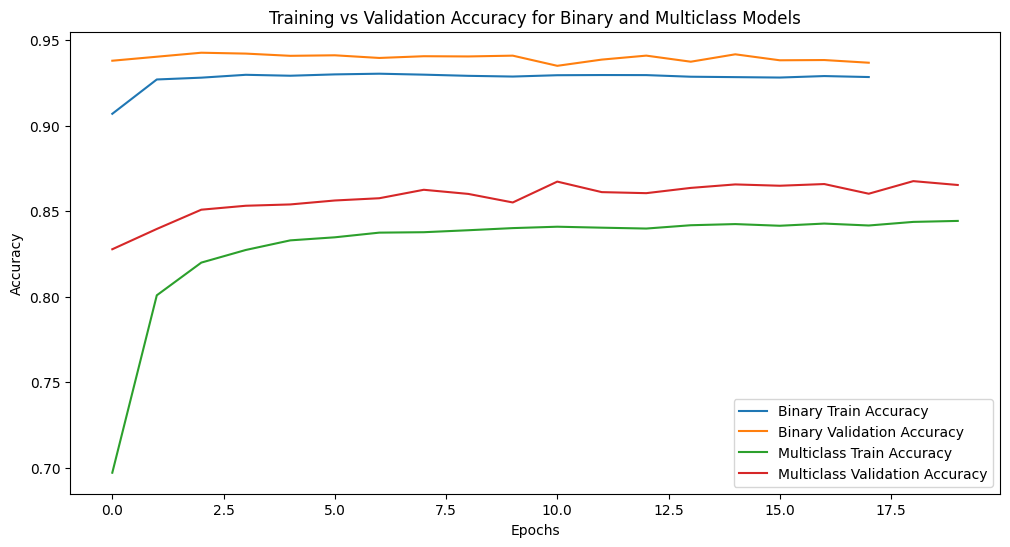

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
import time

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Encode 'tld' and 'url_type'
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df['tld_encoded'] = label_encoder_tld.fit_transform(df['tld'].astype(str))
df['url_type_encoded'] = label_encoder_url_type.fit_transform(df['url_type'].astype(str))

# Add binary labels for binary classification
df['binary_label'] = (df['url_type'] != 'benign').astype(int)  # 'benign' -> 0, others -> 1

# Define features
features = ['domainUrlRatio', 'host_DigitCount', 'subDirLen', 'pathurlRatio', 'domain_token_count', 'NumberofDotsinURL', 'CharacterContinuityRate', 'SymbolCount_Directoryname', 'NumberRate_Domain', 'ldl_path', 'pathDomainRatio', 'URL_sensitiveWord', 'ldl_domain', 'Entropy_Domain', 'spcharUrl', 'sub-Directory_LongestWordLength', 'ldl_url', 'argDomanRatio', 'ldl_filename', 'Filename_LetterCount']

# Binary Classification
def binary_classification(df, features):
    print("Running Binary Classification...")
    X = df[features].astype(np.float32)
    y = df['binary_label']

    # Balance the dataset
    under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_resampled, y_resampled = under_sampler.fit_resample(X, y)

    # Scale features
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    # Build the model
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping]
    )

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("Binary Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save the model
    model.save('binary_url_classifier.h5')
    print("Binary model saved as 'binary_url_classifier.h5'")

    return history, model

# Multiclass Classification
def multiclass_classification(df, features):
    print("Running Multiclass Classification...")
    X = df[features].astype(np.float32)
    y = to_categorical(df['url_type_encoded'])

    # Balance the dataset
    under_sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
    X_resampled, y_resampled = under_sampler.fit_resample(X, df['url_type_encoded'])
    y_resampled = to_categorical(y_resampled)

    # Scale features
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled.argmax(axis=1)
    )

    # Build the model
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')  # Multiclass output
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping]
    )

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    print("Multiclass Classification Report:")
    print(classification_report(y_test_labels, y_pred))

    # Save the model
    model.save('multiclass_url_classifier.h5')
    print("Multiclass model saved as 'multiclass_url_classifier.h5'")

    return history, model

# Run Binary Classification
binary_history, binary_model = binary_classification(df, features)

# Run Multiclass Classification
multiclass_history, multiclass_model = multiclass_classification(df, features)

# Plotting training accuracy for both models
plt.figure(figsize=(12, 6))
plt.plot(binary_history.history['accuracy'], label='Binary Train Accuracy')
plt.plot(binary_history.history['val_accuracy'], label='Binary Validation Accuracy')
plt.plot(multiclass_history.history['accuracy'], label='Multiclass Train Accuracy')
plt.plot(multiclass_history.history['val_accuracy'], label='Multiclass Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy for Binary and Multiclass Models')
plt.show()


Running Binary Classification...
Epoch 1/50


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1953/1953 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8751 - loss: 0.6026 - val_accuracy: 0.9371 - val_loss: 0.1970
Epoch 2/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9235 - loss: 0.2260 - val_accuracy: 0.9404 - val_loss: 0.1849
Epoch 3/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9267 - loss: 0.2173 - val_accuracy: 0.9394 - val_loss: 0.1869
Epoch 4/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9266 - loss: 0.2174 - val_accuracy: 0.9419 - val_loss: 0.1821
Epoch 5/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9291 - loss: 0.2130 - val_accuracy: 0.9401 - val_loss: 0.1869
Epoch 6/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9280 - loss: 0.2139 - val_accuracy: 0.9410 - val_loss: 0.1841
Epoch 7/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9278 - loss: 0.2136 - val_accuracy: 0.9363 - val_loss: 0.1886
Epoch 8/50
1953/1953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9266 - loss: 0.2175 - val_accurac

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     66927
           1       0.96      0.92      0.94     66926

    accuracy                           0.94    133853
   macro avg       0.94      0.94      0.94    133853
weighted avg       0.94      0.94      0.94    133853

Binary model saved as 'binary_url_classifier.h5'
Running Multiclass Classification...
Epoch 1/50


c:\Users\arell\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6001 - loss: 1.6822 - val_accuracy: 0.8236 - val_loss: 0.7665
Epoch 2/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7896 - loss: 0.7746 - val_accuracy: 0.8426 - val_loss: 0.5342
Epoch 3/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8172 - loss: 0.5970 - val_accuracy: 0.8485 - val_loss: 0.4803
Epoch 4/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8273 - loss: 0.5464 - val_accuracy: 0.8556 - val_loss: 0.4449
Epoch 5/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8289 - loss: 0.5318 - val_accuracy: 0.8563 - val_loss: 0.4371
Epoch 6/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8344 - loss: 0.5178 - val_accuracy: 0.8604 - val_loss: 0.4289
Epoch 7/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8372 - loss: 0.5112 - val_accuracy: 0.8606 - val_loss: 0.4244
Epoch 8/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8391 - loss: 0.5050 - val_accuracy: 0.8576 - val_

Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      9756
           1       0.86      0.93      0.89      9756
           2       0.89      0.85      0.87      9756
           3       0.86      0.79      0.83      9756

    accuracy                           0.87     39024
   macro avg       0.87      0.87      0.87     39024
weighted avg       0.87      0.87      0.87     39024

Multiclass model saved as 'multiclass_url_classifier.h5'


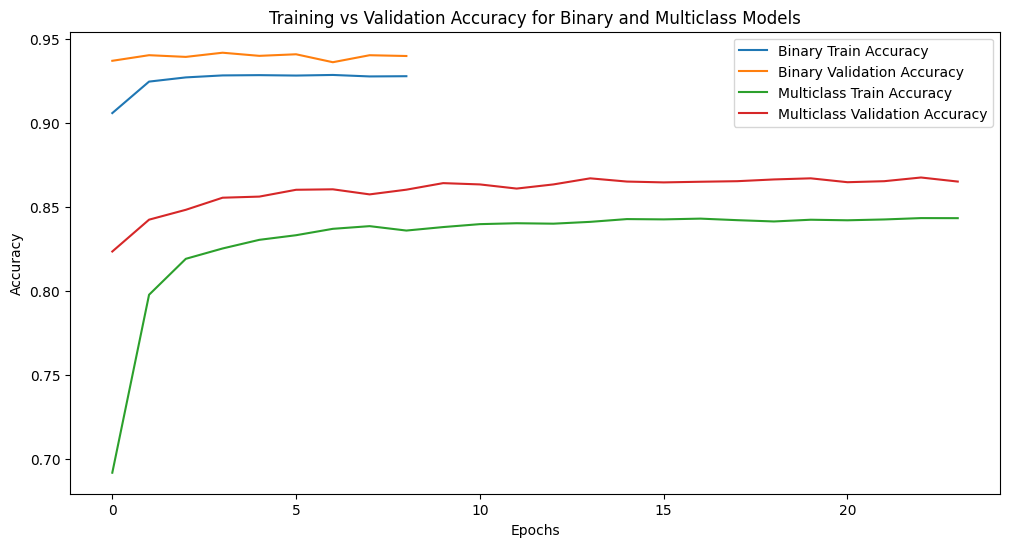

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Encode 'tld' and 'url_type'
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df['tld_encoded'] = label_encoder_tld.fit_transform(df['tld'].astype(str))
df['url_type_encoded'] = label_encoder_url_type.fit_transform(df['url_type'].astype(str))

# Add binary labels for binary classification
df['binary_label'] = (df['url_type'] != 'benign').astype(int)  # 'benign' -> 0, others -> 1

# Define features
features = [
    'domainUrlRatio', 'host_DigitCount', 'subDirLen', 'pathurlRatio',
    'domain_token_count', 'NumberofDotsinURL', 'CharacterContinuityRate',
    'SymbolCount_Directoryname', 'NumberRate_Domain', 'ldl_path',
    'pathDomainRatio', 'URL_sensitiveWord', 'ldl_domain', 'Entropy_Domain',
    'spcharUrl', 'sub-Directory_LongestWordLength', 'ldl_url', 'argDomanRatio',
    'ldl_filename', 'Filename_LetterCount'
]

# Binary Classification Function
def binary_classification(df, features):
    print("Running Binary Classification...")
    X = df[features].astype(np.float32)
    y = df['binary_label']

    # Balance the dataset
    under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_resampled, y_resampled = under_sampler.fit_resample(X, y)

    # Scale features
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    # Build the model
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping]
    )

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print("Binary Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save the model
    model.save('binary_url_classifier.h5')
    print("Binary model saved as 'binary_url_classifier.h5'")

    return history, model

# Multiclass Classification Function
def multiclass_classification(df, features):
    print("Running Multiclass Classification...")
    X = df[features].astype(np.float32)
    y = to_categorical(df['url_type_encoded'])

    # Balance the dataset
    under_sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
    X_resampled, y_resampled = under_sampler.fit_resample(X, df['url_type_encoded'])
    y_resampled = to_categorical(y_resampled)

    # Scale features
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled.argmax(axis=1)
    )

    # Build the model
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')  # Multiclass output
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping]
    )

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    print("Multiclass Classification Report:")
    print(classification_report(y_test_labels, y_pred))

    # Save the model
    model.save('multiclass_url_classifier.h5')
    print("Multiclass model saved as 'multiclass_url_classifier.h5'")

    return history, model

# Run Binary Classification
binary_history, binary_model = binary_classification(df, features)

# Run Multiclass Classification
multiclass_history, multiclass_model = multiclass_classification(df, features)

# Plotting training accuracy for both models
plt.figure(figsize=(12, 6))
plt.plot(binary_history.history['accuracy'], label='Binary Train Accuracy')
plt.plot(binary_history.history['val_accuracy'], label='Binary Validation Accuracy')
plt.plot(multiclass_history.history['accuracy'], label='Multiclass Train Accuracy')
plt.plot(multiclass_history.history['val_accuracy'], label='Multiclass Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy for Binary and Multiclass Models')
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
import os
import joblib
import time
import psutil

# Start measuring time and resources
start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
start_cpu_times = process.cpu_times()

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count', 'avgdomaintokenlen', 'longdomaintokenlen', 
            'avgpathtokenlen', 'tld', 'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 
            'ldl_filename', 'ldl_getArg', 'subDirLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio', 
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio', 'argPathRatio', 'executable', 
            'isPortEighty', 'NumberofDotsinURL', 'ISIpAddressInDomainName', 'CharacterContinuityRate', 
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount', 'Directory_DigitCount', 
            'File_name_DigitCount', 'Extension_DigitCount', 'Query_DigitCount', 'URL_Letter_Count', 
            'host_letter_count', 'Directory_LetterCount', 'Filename_LetterCount', 'Extension_LetterCount', 
            'Query_LetterCount', 'LongestPathTokenLength', 'Domain_LongestWordLength', 'Path_LongestWordLength', 
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength', 'URL_sensitiveWord', 
            'URLQueries_variable', 'spcharUrl', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count', 
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName', 'NumberRate_FileName', 
            'NumberRate_Extension', 'NumberRate_AfterPath', 'SymbolCount_URL', 'SymbolCount_Domain', 
            'SymbolCount_Directoryname', 'SymbolCount_FileName', 'SymbolCount_Extension', 'SymbolCount_Afterpath', 
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension', 'Entropy_Afterpath']

# Clean the dataset
df_cleaned = df.copy()
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

numeric_features = [f for f in features if f not in ['tld', 'url_type']]
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Encode categorical features
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Set up features and binary labels
X = df_cleaned[numeric_features + ['tld_encoded']]
y_binary = df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Multiclass labels
y_multiclass = df_cleaned['url_type_encoded']

# RFE for feature selection
dt_classifier = DecisionTreeClassifier(random_state=42)
rfe_selector = RFE(estimator=dt_classifier, n_features_to_select=25)
X_selected = rfe_selector.fit_transform(X, y_binary)
selected_features = [numeric_features[i] for i in range(len(numeric_features)) if rfe_selector.support_[i]]

# Undersampling for binary classification
under_sampler = RandomUnderSampler(sampling_strategy={label: 40000 for label in y_binary.unique()}, random_state=42)
X_resampled_binary, y_resampled_binary = under_sampler.fit_resample(X_selected, y_binary)

# Binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_resampled_binary, y_resampled_binary, test_size=0.3, random_state=42, stratify=y_resampled_binary
)

dt_classifier.fit(X_train_binary, y_train_binary)
y_pred_binary = dt_classifier.predict(X_test_binary)

print("Binary Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))
print(f"Binary Classification Accuracy: {accuracy_score(y_test_binary, y_pred_binary):.4f}")

# Multiclass classification for malicious URLs
malicious_idx = np.where(y_pred_binary == 1)[0]
X_malicious = X_test_binary[malicious_idx]
y_malicious = y_multiclass.iloc[malicious_idx]

dt_classifier.fit(X_resampled_binary[malicious_idx], y_malicious)
y_pred_multiclass = dt_classifier.predict(X_malicious)

print("Multiclass Classification Report:")
print(classification_report(y_malicious, y_pred_multiclass))
print(f"Multiclass Classification Accuracy: {accuracy_score(y_malicious, y_pred_multiclass):.4f}")

# Resource usage
end_time = time.time()
end_memory = process.memory_info().rss / (1024 ** 2)
end_cpu_times = process.cpu_times()

print(f"Execution Time: {end_time - start_time:.2f} seconds")
print(f"Memory Used: {end_memory - start_memory:.2f} MB")
print(f"CPU Times - User: {end_cpu_times.user - start_cpu_times.user:.2f}s, "
      f"System: {end_cpu_times.system - start_cpu_times.system:.2f}s")


: 